# Set-up

In [4]:
import os
import sys
import numpy as np
import pandas as pd
import mudata as mu
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")


import sys
sys.path.append("/cellar/users/aklie/opt/gene_program_evaluation")

%matplotlib inline

In [7]:
# Path to mudata
path_mdata = "/cellar/users/aklie/data/datasets/paul15/analysis/celloracle/2024_05_21/celloracle.h5mu"

# Load data

In [8]:
# MuData
mdata = mu.read_h5mu(path_mdata)
mdata

/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MuData object with n_obs × n_vars = 2671 × 1999
  obs:	'louvain_annot'
  var:	'n_counts', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators'
  uns:	'grn', 'tutorial_grn'
  1 modality
    rna:	2671 x 1999
      obs:	'paul15_clusters', 'n_counts_all', 'n_counts', 'louvain', 'cell_type', 'louvain_annot', 'Lineage_MEP', 'Lineage_GMP', 'Pseudotime_Lineage_MEP', 'Pseudotime_Lineage_GMP', 'Pseudotime'
      var:	'n_counts', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators'
      uns:	'cell_type_colors', 'diffmap_evals', 'draw_graph', 'iroot', 'log1p', 'louvain', 'louvain_annot_colors', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'paul15_clusters_colors', 'pca'
      obsm:	'X_diffmap', 'X_draw_graph_fa', 'X_pca'
      varm:	'PCs'
      layers:	'imputed_count', 'normalized_count', 'raw_count', 'scaled_imputed_counts'
      obsp:	'connectivities', 'distances'

# GRN selection

In [9]:
# Parameters
pval = 0.001
score = 0
ntop = 2000
layer = None
grn_cluster_key = "cluster"
cluster = "MEP_0"
grn_key = "tutorial_grn"
min_regulators = 0
min_targets = 0

In [10]:
# Read in grns
grn = mdata.uns[grn_key]
print(f"Initial GRN has {len(grn)} edges")

Initial GRN has 1716652 edges


In [11]:
#mp = {0: "SC.alpha", 1: "SC.beta", 2: "SC.EC.1", 3: "SC.EC.2"}
#grn["cluster"] = grn["celltype"].astype(int).map(mp)

In [12]:
# Choose a cluster of interest (based on cluster column values in standardized outputs)
grn = grn[grn[grn_cluster_key] == cluster]
print(f"GRN for {cluster} has {len(grn)} edges")

GRN for MEP_0 has 73700 edges


In [13]:
# If pval and score are not None, filter based on these thresholds
if pval is not None:
    grn = grn[grn["pval"] <= pval]
if score is not None:
    grn = grn[np.abs(grn["score"]) >= score]
print(f"GRN after filtering on edge strength has {len(grn)} edges")

GRN after filtering on edge strength has 35194 edges


In [14]:
# Keep only the top ntop regulators if ntop is not None, use abs value of score
if ntop is not None:
    grn["score_abs"] = np.abs(grn["score"])
    grn = grn.sort_values("score_abs", ascending=False)
    grn = grn.head(ntop)
    grn = grn.drop(columns="score_abs")
print(f"GRN after filtering on top regulators has {len(grn)} edges")

GRN after filtering on top regulators has 2000 edges


In [15]:
# Filter out any tfs that regulate fewer than min_targets genes
tfs = grn["tf"].value_counts()
tfs = tfs[tfs > min_targets].index
grn = grn[grn["tf"].isin(tfs)]
print(f"GRN after filtering on minimum number of targets has {len(grn)} edges")

GRN after filtering on minimum number of targets has 2000 edges


In [16]:
# Filter out any genes that are regulated by fewer than min_regulators tfs
genes = grn["gene"].value_counts()
genes = genes[genes >= min_regulators].index
grn = grn[grn["gene"].isin(genes)]
print(f"GRN after filtering on minimum number of regulators has {len(grn)} edges")

GRN after filtering on minimum number of regulators has 2000 edges


# 

# Choose enrichment method

In [17]:
method = "aucell"
layer = "imputed_count"
cluster_key = "louvain_annot"
dim_reduction_key = "X_pca"

In [18]:
import mudata
import decoupler as dc

ENRICHMENT_METHODS = {
    "aucell": dc.run_aucell,
    "gsea": dc.run_gsea,
    "gsva": dc.run_gsva,
    "mdt": dc.run_mdt,
    "mlm": dc.run_mlm,
    "ora": dc.run_ora,
    "udt": dc.run_udt,
    "ulm": dc.run_ulm,
    "viper": dc.run_viper,
    "wmean": dc.run_wmean,
    "wsum": dc.run_wsum,
    "consensus": dc.run_consensus,
}

def _compute_tf_enrichment(
    grn: pd.DataFrame,
    adata: sc.AnnData,
    source: str = "tf",
    target: str = "gene",
    method: str = "aucell",
    score: str = "score",
    layer: str = None,
    min_n: int = 5,
    seed: int = 1234,
):
    adata_cp = adata.copy()
    if layer is not None:
        if layer not in adata_cp.layers:
            raise ValueError(f"Layer {layer} not found in adata.layers")
        adata_cp.X = adata_cp.layers[layer].copy()
    else:
        print("No layer provided, assuming we need to log normalize the matrix X")
        sc.pp.normalize_total(adata_cp, target_sum=1e4)
        sc.pp.log1p(adata_cp)

    # Run enrichment
    ENRICHMENT_METHODS[method](
        mat=adata_cp,
        net=grn,
        source=source,
        target=target,
        min_n=min_n,
        use_raw=False,
        seed=seed
    )

    # Get activities
    acts = dc.get_acts(adata_cp, obsm_key=f'{method}_estimate')

    # Create adjacency matrix
    adj = grn.pivot_table(index=target, columns=source, values=score, fill_value=0)
    adj = adj[acts.var_names]
    adj = adj.reindex(adata.var_names, fill_value=0)
    acts.varm['loadings'] = adj.T.values

    return acts

In [19]:
# Get the RNA anndata
rna = mdata.mod["rna"].copy()
rna

AnnData object with n_obs × n_vars = 2671 × 1999
    obs: 'paul15_clusters', 'n_counts_all', 'n_counts', 'louvain', 'cell_type', 'louvain_annot', 'Lineage_MEP', 'Lineage_GMP', 'Pseudotime_Lineage_MEP', 'Pseudotime_Lineage_GMP', 'Pseudotime'
    var: 'n_counts', 'symbol', 'isin_top1000_var_mean_genes', 'isin_TFdict_targets', 'isin_TFdict_regulators'
    uns: 'cell_type_colors', 'diffmap_evals', 'draw_graph', 'iroot', 'log1p', 'louvain', 'louvain_annot_colors', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'paul15_clusters_colors', 'pca'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count', 'scaled_imputed_counts'
    obsp: 'connectivities', 'distances'

In [20]:
# 
enrich = _compute_tf_enrichment(
    grn=grn,
    adata=rna,
    source="tf",
    target="gene",
    method=method,
    layer=layer,
    min_n=5,
    seed=1234,
)

In [21]:
# Remove any all 0 features
enrich = enrich[:, enrich.X.sum(axis=0) > 0]
enrich

View of AnnData object with n_obs × n_vars = 2671 × 64
    obs: 'paul15_clusters', 'n_counts_all', 'n_counts', 'louvain', 'cell_type', 'louvain_annot', 'Lineage_MEP', 'Lineage_GMP', 'Pseudotime_Lineage_MEP', 'Pseudotime_Lineage_GMP', 'Pseudotime'
    uns: 'cell_type_colors', 'diffmap_evals', 'draw_graph', 'iroot', 'log1p', 'louvain', 'louvain_annot_colors', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'paul15_clusters_colors', 'pca'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'aucell_estimate'
    varm: 'loadings'

In [22]:
# Add to mdata
mdata.mod["tf_activity"] = enrich

# Covariate association

In [23]:
from src.evaluation.association_categorical import compute_categorical_association
from src.plotting.plot_topic_trait_relationship_heatmap import plot_topic_trait_relationship_heatmap

In [24]:
# Run associations
association_df, posthoc_df = compute_categorical_association(
    mdata=mdata,
    prog_key="tf_activity",
    categorical_key=cluster_key,
    n_jobs=-1,
    inplace=False,
)
association_df["-log10_p_value"] = -np.log10(association_df[f"{cluster_key}_kruskall_wallis_pval"])
posthoc_df["-log10_p_value"] = -np.log10(posthoc_df["p_value"])

INFO:root:Performing tests at single-cell level. Significance will likely be inflated


Testing louvain_annot association:   0%|          | 0/64 [00:00<?, ?programs/s]

/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/anndata/_core/anndata.py:1179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[k] = df_sub[k].cat.remove_unused_categories()


Identifying differential louvain_annot:   0%|          | 0/64 [00:00<?, ?programs/s]

/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/tmp/ipykernel_2104090/4066577626.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


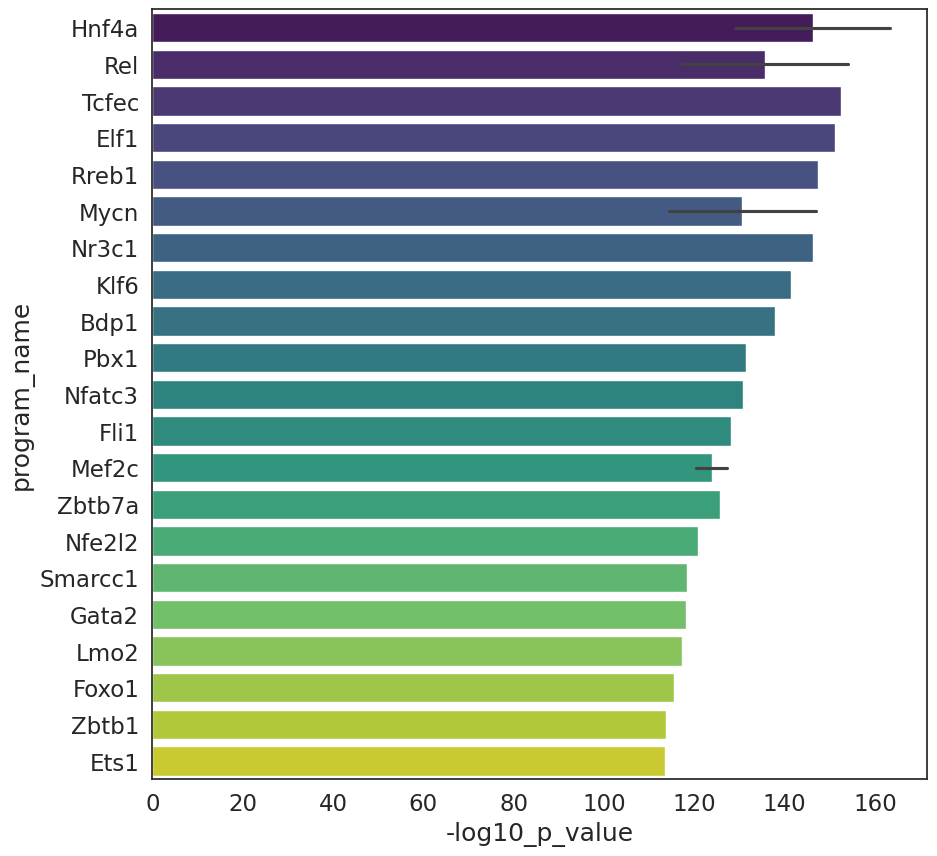

In [25]:
#seaborn barplot for the top 25 tfs
sns.set_style("white")
with sns.plotting_context("notebook", font_scale=1.5):
    plt.figure(figsize=(10, 10))
    sns.barplot(
        x="-log10_p_value",
        y="program_name",
        data=posthoc_df[posthoc_df[f"{cluster_key}_b"] == cluster].sort_values("-log10_p_value", ascending=False).head(25),
        palette="viridis",
    )

In [26]:
# Choose a TF
tf = "Hnf4a"

/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/tmp/ipykernel_2104090/2540931788.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, ha="right")
/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remove

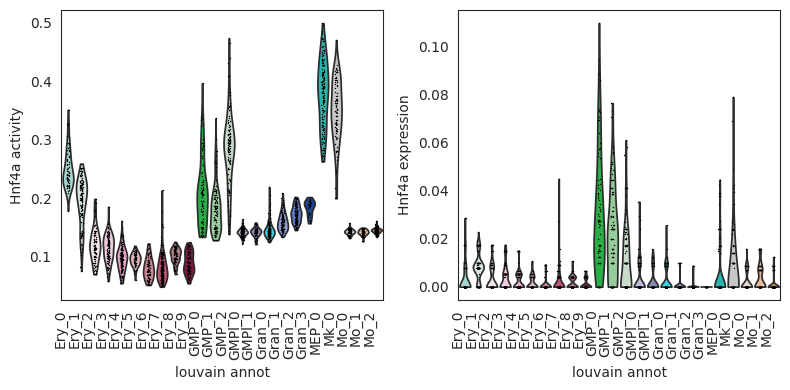

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sc.pl.violin(enrich, groupby="louvain_annot", keys=tf, show=False, ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, ha="right")
ax[0].set_ylabel(f"{tf} activity")
sc.pl.violin(mdata.mod["rna"], groupby="louvain_annot", keys=tf, show=False, ax=ax[1], layer=layer, use_raw=False)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90, ha="right")
ax[1].set_ylabel(f"{tf} expression")
plt.tight_layout()

/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:842: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


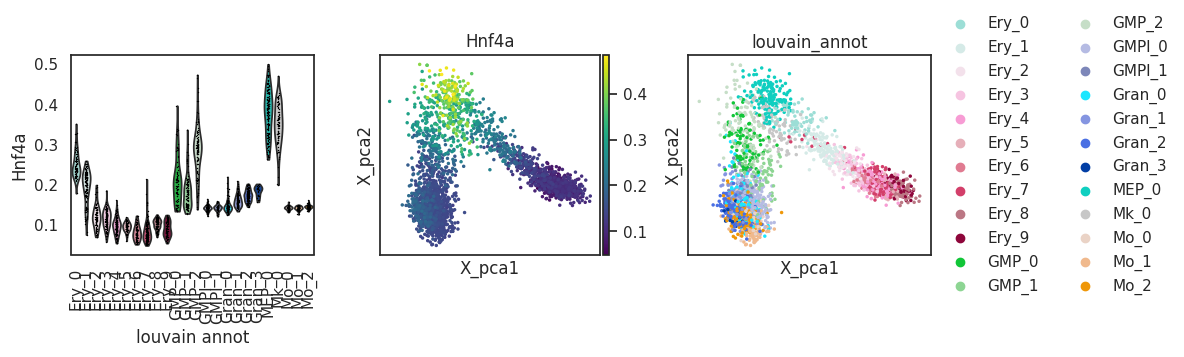

In [29]:
with sns.plotting_context("notebook"):
    _, ax = plt.subplots(1, 3, figsize=(12, 3.5))
    sc.pl.violin(enrich, groupby=cluster_key, keys=tf, show=False, ax=ax[0])
    sc.pl.embedding(enrich, basis=dim_reduction_key, color=[cluster_key], s=25, ax=ax[2], show=False)
    sc.pl.embedding(enrich, basis=dim_reduction_key, color=[tf], s=25, vmax="p99.9", cmap="viridis", ax=ax[1], show=False)
    for tick in ax[0].get_xticklabels():
        tick.set_rotation(90)
    plt.tight_layout()
    ax[0].set_title("")

/cellar/users/aklie/opt/miniconda3/envs/test_celloracle/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


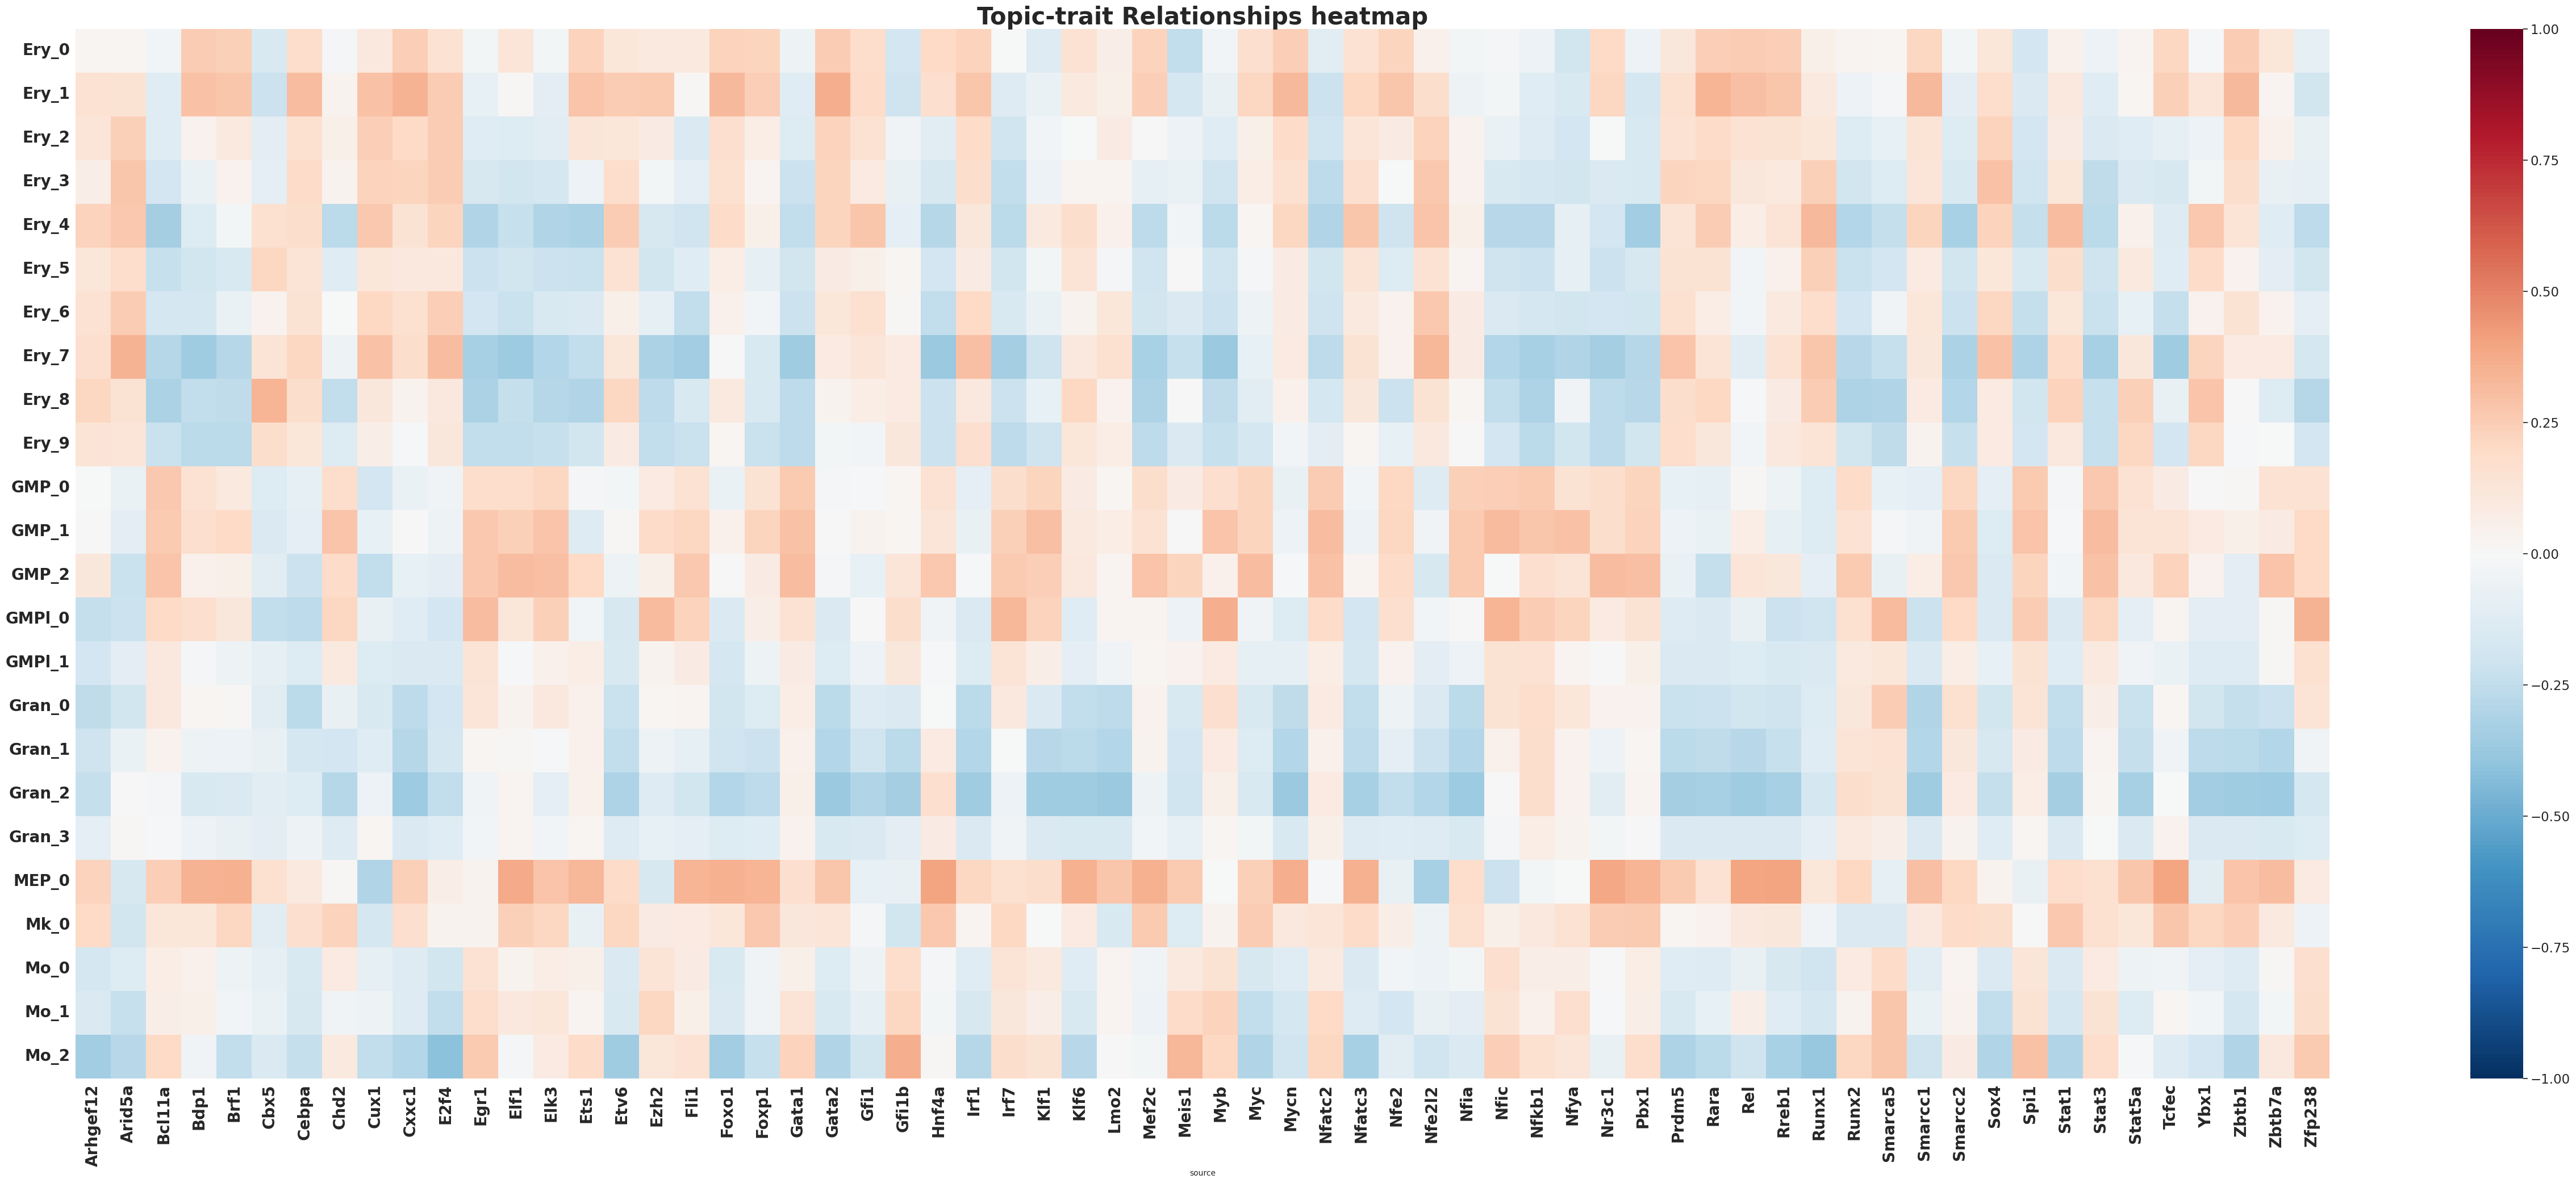

In [30]:
plot_topic_trait_relationship_heatmap(
    cell_topic_participation=enrich,
    metaData=["louvain_annot"],
)

# Gene set enrichment

In [31]:
from src.evaluation.enrichment_geneset import compute_geneset_enrichment
from src.evaluation.enrichment_geneset import get_program_gene_loadings

In [32]:
test = get_program_gene_loadings(
    mdata,
    prog_key="tf_activity",
    data_key="rna",
)

In [47]:
gsea_df = compute_geneset_enrichment(
    mdata=mdata, 
    prog_key='tf_activity',
    library='GO_Biological_Process_2023', 
    organism='mouse',
    method='fisher',
    loading_rank_thresh=50,
    inplace=False, 
    n_jobs=-1
)

INFO:root:Downloading and generating Enrichr library gene sets...
INFO:root:0001 gene_sets have been filtered out when max_size=2000 and min_size=0


Running Fisher enrichment:   0%|          | 0/64 [00:00<?, ?programs/s]

In [114]:
# Choose a TF
tf = "Nfkb1"

/tmp/ipykernel_2104090/1197872380.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




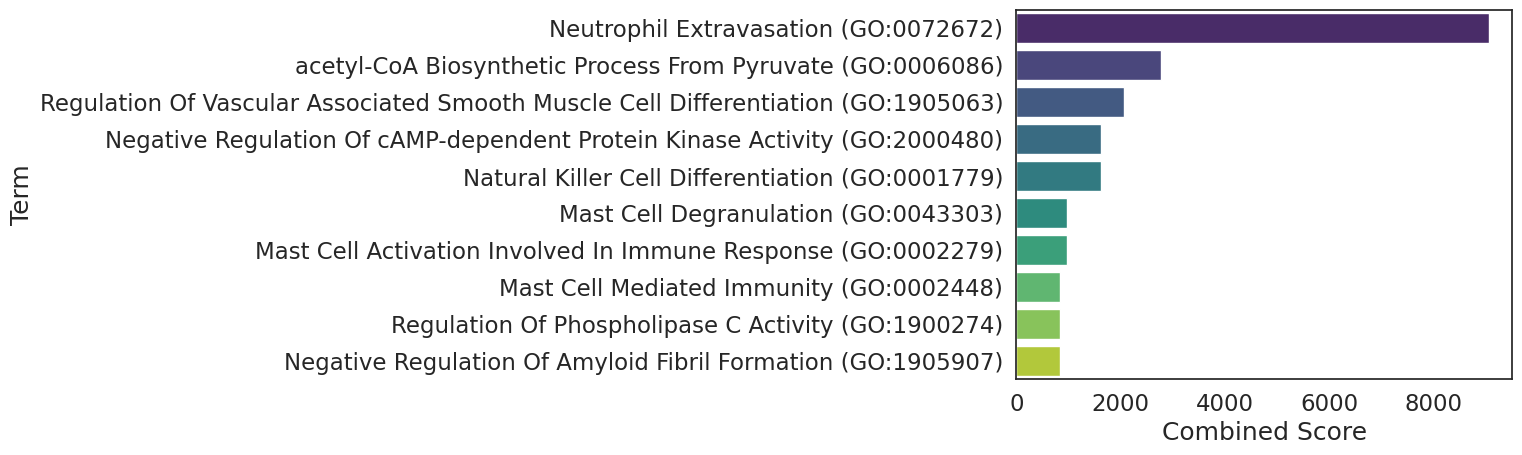

In [115]:
#seaborn barplot for the top 25 tfs
sns.set_style("white")
with sns.plotting_context("notebook", font_scale=1.5):
    sns.barplot(
        x="Combined Score",
        y="Term",
        data=gsea_df[gsea_df["program_name"] == tf].sort_values("Combined Score", ascending=False).head(10),
        palette="viridis",
    )

# GWAS enrichment

In [60]:
from src.evaluation.enrichment_trait import compute_trait_enrichment
from src.plotting.plot_gwas_enrichment import process_enrichment_data, plot_interactive_phewas

In [58]:
gwas_df = compute_trait_enrichment(
    mdata, 
    '/cellar/users/aklie/opt/gene_program_evaluation/smk/resources/OpenTargets_L2G_Filtered.csv.gz', 
    prog_key="tf_activity",
    inplace=False,
    loading_rank_thresh=50
)

Running Fisher enrichment:   0%|          | 0/64 [00:00<?, ?programs/s]

In [62]:
data = process_enrichment_data(
    enrich_res=gwas_df,
    metadata='/cellar/users/aklie/opt/gene_program_evaluation/smk/resources/OpenTargets_L2G_Filtered.csv.gz'
)
data.head(1)

,Term,P-value,trait_efos,trait_category,program_name,trait_reported,Genes,study_id,pmid,-log10(p-value)
0,EFO_0009473,0.000366,EFO_0009473,biological process,Rreb1,hemolysis of donated blood (osmotic),AQP1;HK1,GCST012135,PMID:34014839,3.436879


In [68]:
data[data["program_name"] == "Gata1"].sort_values("-log10(p-value)", ascending=False).head(10)

,Term,P-value,trait_efos,trait_category,program_name,trait_reported,Genes,study_id,pmid,-log10(p-value)
359,EFO_0004584,0.001082,EFO_0004584,measurement,Gata1,Mean platelet volume,TAGLN2;MYB;PDLIM1;PCYT1A;ARPC2,GCST90002349,PMID:32888493,2.965695
406,EFO_0010611,0.008233,EFO_0010611,measurement,Gata1,Cathepsin D levels,CTSD,GCST90012053,PMID:33067605,2.084437
437,EFO_0010071,0.013686,EFO_0010071,measurement,Gata1,High-sensitivity cardiac troponin I concentration,TNFAIP2,GCST90054799,PMID:33961016,1.863726
475,EFO_0007984,0.016731,EFO_0007984,measurement,Gata1,Platelet distribution width,TAGLN2;PDIA5;SMAP2;ARPC2,GCST90002401,PMID:32888494,1.776479
521,EFO_0004872,0.019110,EFO_0004872,measurement,Gata1,Inflammatory biomarkers (multivariate analysis),PDGFRB,GCST90000584,PMID:33110245,1.718735
586,EFO_0004309,0.021517,EFO_0004309,measurement,Gata1,Platelet count,PDIA5;MYC;ARPC2;PDLIM2,GCST90002361,PMID:32888493,1.667221
595,EFO_0007865,0.021812,EFO_0007865,measurement,Gata1,Loneliness,BPTF,GCST009463,PMID:31518406,1.661311
11,EFO_0009473,0.024506,EFO_0009473,biological process,Gata1,hemolysis of donated blood (osmotic),AQP1,GCST012135,PMID:34014839,1.610727
635,EFO_0010619,0.024506,EFO_0010619,measurement,Gata1,Cathepsin L1 levels,TNFAIP2,GCST90012073,PMID:33067605,1.610727
3916,EFO_0003931,0.032547,EFO_0003931,musculoskeletal or connective tissue disease,Gata1,Fractures,AQP1,GCST006980,PMID:30598549,1.487491


In [63]:
plot_interactive_phewas(
    data=data,
    title="Regulons x GWAS Binary Outcome Enrichments",
    query_string="trait_category != 'measurement'"
)

In [64]:
plot_interactive_phewas(
    data=data,
    title="Regulons x GWAS Continuous Outcome Enrichments",
    query_string="trait_category == 'measurement'"
)

# Counts

In [107]:
from plotly.subplots import make_subplots
import plotly.express as px

def count_unique(categorical_var, count_var, dataframe):

    counts_df = dataframe.value_counts([categorical_var, count_var])
    counts_df = counts_df.groupby(categorical_var).sum()
    counts_df = counts_df.sort_values(ascending=False)#.cumsum()

    counts_df = pd.DataFrame(counts_df.reset_index().values, 
                             columns=[categorical_var,
                                      count_var])
    return counts_df

In [108]:
a = count_unique('program_name', 'Term', gsea_df.loc[gsea_df['Adjusted P-value'] <= 0.05])
a['Number of enriched GO terms'] = a['Term']
a = a.drop(columns='Term')
gwas_unique_df = count_unique('program_name', 'Term', gwas_df.loc[gwas_df['Adjusted P-value'] <= 0.10])
gwas_unique_df['Number of enriched GWAS traits'] = gwas_unique_df['Term']
a = a.merge(gwas_unique_df.loc[:, ['program_name', 'Number of enriched GWAS traits']], left_on='program_name', right_on='program_name', how='left').fillna(0)

In [109]:
fig = make_subplots(
    rows=1, cols=2,
    specs=[
            [{}, {}],
            ],
    print_grid=True,
    subplot_titles=('Number of enriched GO terms', 'Number of enriched GWAS traits'),
    vertical_spacing = 0.05, horizontal_spacing = 0.1
)

This is the format of your plot grid:
[ (1,1) x,y   ]  [ (1,2) x2,y2 ]



In [116]:
plots = {}
for i, col in enumerate([col for col in a.columns if 'program_name' not in col]):

    plots[col] = px.scatter(x=a.sort_values(col, ascending=False)['program_name'], 
                            y=a.sort_values(col, ascending=False)[col],)
    plots[col].update_layout(xaxis_title='Components', yaxis_title=col)

    row_num = int((i)/2) + 1
    col_num = i - (row_num-1)*2 + 1
    fig.add_trace(plots[col]['data'][0], row=row_num, col=col_num)
    fig.update_xaxes(showticklabels=False, row=row_num, col=col_num)
    fig.update_yaxes(ticksuffix = "  ", row=row_num, col=col_num)
    
fig.update_traces(hovertemplate="Program Name: %{x} <br> Value: %{y}", marker_color='black')
fig.update_layout(height=500, width=1000, 
                  plot_bgcolor='whitesmoke',
                  title_text="Dashboard - v0.1 - Goodness of fit measures")

In [130]:
from scipy import stats
import plotly.graph_objects as go

In [120]:
# Batch assocation
association_df[f'{cluster_key}_kruskall_wallis_fdr'] = stats.false_discovery_control(association_df[f'{cluster_key}_kruskall_wallis_pval'])
association_df[f'{cluster_key}_kruskall_wallis_neg_log_fdr'] = association_df[f'{cluster_key}_kruskall_wallis_fdr'].apply(lambda x: -np.log(x))
association_df[f'{cluster_key}_kruskall_wallis_log_stat'] = association_df[f'{cluster_key}_kruskall_wallis_stat'].apply(lambda x: np.log(x))

In [122]:
# Program scores across batch
prog_df = pd.DataFrame(mdata['tf_activity'].X, index=mdata['tf_activity'].obs.index)
prog_df[cluster_key] = mdata['tf_activity'].obs[cluster_key]

In [127]:
mdata["tf_activity"]

View of AnnData object with n_obs × n_vars = 2671 × 64
    obs: 'paul15_clusters', 'n_counts_all', 'n_counts', 'louvain', 'cell_type', 'louvain_annot', 'Lineage_MEP', 'Lineage_GMP', 'Pseudotime_Lineage_MEP', 'Pseudotime_Lineage_GMP', 'Pseudotime'
    uns: 'cell_type_colors', 'diffmap_evals', 'draw_graph', 'iroot', 'log1p', 'louvain', 'louvain_annot_colors', 'louvain_colors', 'louvain_sizes', 'neighbors', 'paga', 'paul15_clusters_colors', 'pca'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'aucell_estimate'
    varm: 'loadings'

In [128]:
# Loadings
loadings = pd.DataFrame(mdata['tf_activity'].varm['loadings'], 
                        index=mdata['tf_activity'].var_names).T    
loadings = loadings/abs(loadings).max(axis=0)

In [133]:
# Make figure
fig = make_subplots(rows=2, cols=2,
                    specs=[
                           [{}, {}],
                           [{'colspan':2}, None],
                          ],
                    print_grid=True,
                    subplot_titles=('Enrichment w.r.t. louvain_annot', 
                                    'Program distribution across louvain_annot', 
                                    'Program-gene loadings (normalised)'),
                    vertical_spacing = 0.1, 
                    horizontal_spacing = 0.1)

for k, r in enumerate([col for col in prog_df.columns if col not in ['sample', 'louvain_annot']]):
       # Plot volcano
       volcano = go.Scatter(x=association_df.louvain_annot_sample_kruskall_wallis_log_stat,
                            y=association_df.louvain_annot_sample_kruskall_wallis_neg_log_fdr,
                            customdata=association_df.index.values,
                            hovertemplate=" Program Name: %{customdata}",
                            showlegend=False, mode='markers', 
                            visible=True if k == 0 else False,
                            marker_color='black',
                            )
       fig.add_trace(volcano, row=1, col=1)
       fig.update_xaxes(showticklabels=False, row=1, col=1)
       fig.update_yaxes(title='Neg. log adjusted pval', ticksuffix = "  ", row=1, col=1)

# Plot box
for k, r in enumerate([col for col in prog_df.columns if col not in ['sample', 'louvain_annot']]):

    fig.add_trace(
                  go.Box(x=prog_df.louvain_annot, 
                         y=prog_df[r],
                         visible=True if k == 0 else False,
                         customdata=prog_df.index.values,
                         hovertemplate="Cell barcode: %{customdata}",
                         marker_color='black',
                        ), 
                   row=1, col=2)
# fig.update_xaxes(showticklabels=False, row=2, col=1)
fig.update_yaxes(ticksuffix = "  ", row=1, col=2)

# Plot loadings
for k, r in enumerate(loadings.columns):

    dfp = loadings.sort_values(r, ascending=False)[:100]
    fig.add_trace(
                  go.Bar(x=dfp.index, 
                         y=dfp[r],
                         name='', 
                         orientation='v',
                         hovertemplate="Gene Name: %{x} <br> Loading: %{y}",
                         visible=True if k == 0 else False,
                         marker_color='black',
                        ), 
                   row=2, col=1)
fig.update_xaxes(showticklabels=False, row=2, col=1)
fig.update_yaxes(tickvals=np.arange(0,1.25,0.25), ticksuffix = "  ", row=2, col=1)
        
# Define buttons for dropdown
col_opts = list(loadings.columns)
buttons_opts = []
for i, opt in enumerate(col_opts):
    args = [False] * len(col_opts)
    args[i] = True
    buttons_opts.append(
        dict(
             method='update',
             label=opt,
             args=[{
                    'visible': args, #this is the key line!
                    'title': opt,
                    'showlegend': False
                   }]
            ))
    
fig.update_layout(height=700, width=1000, 
                  plot_bgcolor='whitesmoke',

                  title_text="GEP Dashboard - v0.1 - Investigate GEPs",
                  updatemenus = [go.layout.Updatemenu(
                                 active=0,
                                 buttons=buttons_opts,
                                 x=-0.1,
                                 xanchor='left',
                                 y=1,
                                 yanchor='bottom')]
                 )

This is the format of your plot grid:
[ (1,1) x,y   ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3           -      ]



AttributeError: 'DataFrame' object has no attribute 'louvain_annot_sample_kruskall_wallis_log_stat'

# DONE!

---

In [ ]:
from src.evaluation.explained_variance import compute_explained_variance_ratio
explained_variance = compute_explained_variance_ratio(
    mdata=mdata,
    prog_key="tf_activity",
    data_key="rna",
    layer="X",
    n_jobs=-1,
    inplace=False
)